# Final Project Submission
Please fill out:

* Student name: Michael Flores
* Student pace: Full time
* Scheduled project review date/time:
* Instructor name: Abhineet Kulkarni
* Blog post URL:

# Importing Libraries

In [119]:
import os, shutil
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_confusion_matrix
from keras import models, optimizers
from keras import layers
from tensorflow.keras.layers import BatchNormalization

%matplotlib inline

np.random.seed(123)

# Importing Data

All of the images we will used are contained within the chest_xray folder. The images have already been split into test, training and validation folders.

In [120]:
# Creating filepaths for all the folders
test_pne = 'chest_xray/test/PNEUMONIA'
test_norm = 'chest_xray/test/NORMAL'
train_pne = 'chest_xray/train/PNEUMONIA'
train_norm = 'chest_xray/train/NORMAL'
val_pne = 'chest_xray/val/PNEUMONIA'
val_norm = 'chest_xray/val/NORMAL'

test_dir = 'chest_xray/test/'
train_dir = 'chest_xray/train/'
val_dir = 'chest_xray/val/'

In [121]:
folders = [test_pne,test_norm, train_pne, train_norm, val_pne, val_norm]

In [122]:
for folder_name in folders: 
    print('There are', len(os.listdir(folder_name)), 'xray images in the', folder_name, 'set')

There are 390 xray images in the chest_xray/test/PNEUMONIA set
There are 234 xray images in the chest_xray/test/NORMAL set
There are 3876 xray images in the chest_xray/train/PNEUMONIA set
There are 1342 xray images in the chest_xray/train/NORMAL set
There are 9 xray images in the chest_xray/val/PNEUMONIA set
There are 9 xray images in the chest_xray/val/NORMAL set


In [123]:
normal_count = 0
pne_count = 0
for folder_name in folders:
    if 'NORMAL' in str(folder_name):
        normal_count += len(os.listdir(folder_name))
    else:
        pne_count += len(os.listdir(folder_name))
        
print('There are', normal_count, 'normal chest xrays')
print('There are', pne_count, 'pneumonia chest xrays')

There are 1585 normal chest xrays
There are 4275 pneumonia chest xrays


In [124]:
pne_test_images =  [file for file in os.listdir(test_pne) if file.endswith('.jpeg')]

In [125]:
pne_test_images[0:10]

['person100_bacteria_475.jpeg',
 'person100_bacteria_477.jpeg',
 'person100_bacteria_478.jpeg',
 'person100_bacteria_479.jpeg',
 'person100_bacteria_480.jpeg',
 'person100_bacteria_481.jpeg',
 'person100_bacteria_482.jpeg',
 'person101_bacteria_483.jpeg',
 'person101_bacteria_484.jpeg',
 'person101_bacteria_485.jpeg']

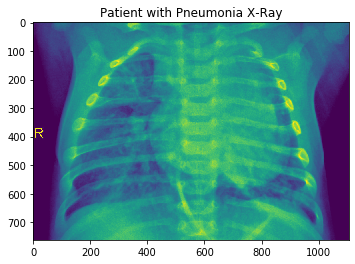

In [126]:
pne_img = mpimg.imread(test_pne +'/' + pne_test_images[0])
imgplot = plt.imshow(pne_img)
plt.title('Patient with Pneumonia X-Ray')
plt.show()

(1, 128, 128, 3)


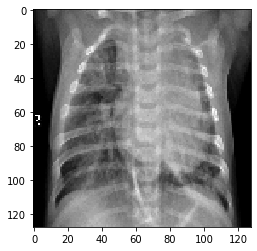

In [180]:
img_path = test_pne +'/' + pne_test_images[0]

img = image.load_img(img_path, target_size=(128, 128))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

In [127]:
norm_test_images =  [file for file in os.listdir(test_norm) if file.endswith('.jpeg')]

In [128]:
norm_test_images[0:5]

['IM-0001-0001.jpeg',
 'IM-0003-0001.jpeg',
 'IM-0005-0001.jpeg',
 'IM-0006-0001.jpeg',
 'IM-0007-0001.jpeg']

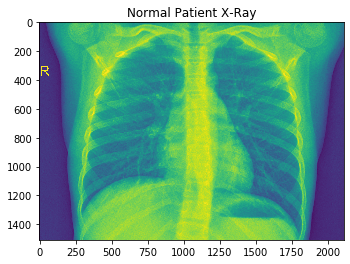

In [129]:
norm_img = mpimg.imread(test_norm +'/' + norm_test_images[1])
imgplot = plt.imshow(norm_img)
plt.title('Normal Patient X-Ray')
plt.show()

# Densely Connected Network (Baseline)

I will be using a densely connected network with no convolutional layers as a baseline model to test against. This model was meant to ensure that the file systems and images are correctly in place. This will not be used for evaluating the test images at all.

In [130]:
# get all the data in the directory data/test (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(128, 128), batch_size = 624) 

# get all the data in the directory data/validation (18 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(128, 128), batch_size = 18)

# get all the data in the directory data/train (5218 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(128, 128), batch_size=5218)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [131]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [132]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 128, 128, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 128, 128, 3)
test_labels shape: (624, 2)
val_images shape: (16, 128, 128, 3)
val_labels shape: (16, 2)


In [133]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 49152)
(624, 49152)
(16, 49152)


In [134]:
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [135]:
early_stopping_base = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_baseline.h5', monitor='val_loss', save_best_only=True)]

In [32]:
# Build a baseline fully connected model

np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(49152,))) # 2 hidden layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [33]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

baseline = model.fit(train_img,
                    train_y,
                    epochs=50,
                    callbacks = early_stopping_base,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
163/163 [==============================] - 3s 17ms/step - loss: 0.4817 - accuracy: 0.7749 - val_loss: 0.5240 - val_accuracy: 0.7500
Epoch 2/50
163/163 [==============================] - 3s 16ms/step - loss: 0.3227 - accuracy: 0.8583 - val_loss: 0.8661 - val_accuracy: 0.6875
Epoch 3/50
163/163 [==============================] - 3s 16ms/step - loss: 0.2682 - accuracy: 0.8907 - val_loss: 0.4691 - val_accuracy: 0.8125
Epoch 4/50
163/163 [==============================] - 3s 16ms/step - loss: 0.2031 - accuracy: 0.9156 - val_loss: 0.3986 - val_accuracy: 0.8750
Epoch 5/50
163/163 [==============================] - 3s 17ms/step - loss: 0.1874 - accuracy: 0.9241 - val_loss: 0.2614 - val_accuracy: 0.9375
Epoch 6/50
163/163 [==============================] - 3s 17ms/step - loss: 0.1931 - accuracy: 0.9239 - val_loss: 0.4722 - val_accuracy: 0.8125
Epoch 7/50
163/163 [==============================] - 3s 17ms/step - loss: 0.1714 - accuracy: 0.9350 - val_loss: 0.2552 - val_accuracy: 0.8750

In [34]:
# Function designed to plot accuracy and loss for both 
# test and validation sets
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['Validation Loss', 'Training Loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['Validation Accuracy', 'Training Accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

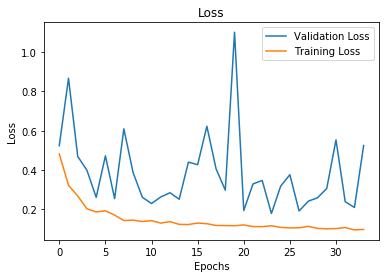

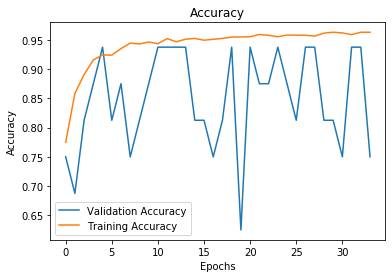

In [35]:
visualize_training_results(baseline)

# Convolutional Neural Networks

## CNN Baseline

In [39]:
# Define the callbacks
early_stopping_cnn = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_cnn.h5', monitor='val_loss', save_best_only=True)]

In [40]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [41]:
cnn_model = cnn_model.fit(train_images,
                    train_y,
                    epochs=50,
                    callbacks = early_stopping_cnn,
                    batch_size=64,
                    validation_data=(val_images, val_y))

Epoch 1/50
82/82 [==============================] - 55s 666ms/step - loss: 0.5919 - accuracy: 0.7429 - val_loss: 0.7920 - val_accuracy: 0.5000
Epoch 2/50
82/82 [==============================] - 51s 622ms/step - loss: 0.5597 - accuracy: 0.7429 - val_loss: 0.8332 - val_accuracy: 0.5000
Epoch 3/50
82/82 [==============================] - 54s 657ms/step - loss: 0.5346 - accuracy: 0.7429 - val_loss: 0.7899 - val_accuracy: 0.5000
Epoch 4/50
82/82 [==============================] - 52s 636ms/step - loss: 0.4956 - accuracy: 0.7661 - val_loss: 0.6105 - val_accuracy: 0.6875
Epoch 5/50
82/82 [==============================] - 50s 607ms/step - loss: 0.4294 - accuracy: 0.8094 - val_loss: 1.0749 - val_accuracy: 0.5625
Epoch 6/50
82/82 [==============================] - 50s 609ms/step - loss: 0.3468 - accuracy: 0.8503 - val_loss: 0.7375 - val_accuracy: 0.6250
Epoch 7/50
82/82 [==============================] - 50s 612ms/step - loss: 0.2634 - accuracy: 0.8959 - val_loss: 0.6811 - val_accuracy: 0.6250

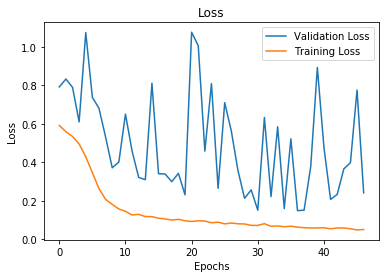

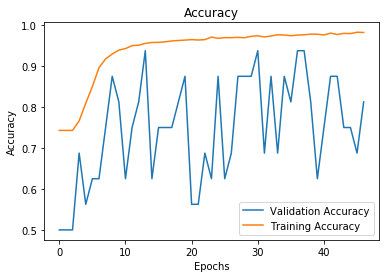

In [42]:
visualize_training_results(cnn_model)

In [43]:
saved_model_cnn = load_model('Models/best_model_cnn.h5')

In [44]:
results_train = saved_model_cnn.evaluate(train_images, train_y)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model_cnn.evaluate(test_images, test_y)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

163/163 [==============================] - 15s 90ms/step - loss: 0.0773 - accuracy: 0.9699
Training Loss: 0.0773 
Training Accuracy: 0.97
----------
20/20 [==============================] - 2s 87ms/step - loss: 0.7243 - accuracy: 0.7901
Test Loss: 0.724 
Test Accuracy: 0.79


In [45]:
predictions_cnn = saved_model_cnn.predict_classes(test_images)
print(classification_report(test_y, predictions_cnn, target_names = ['Normal','Pneumonia']))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

      Normal       0.76      0.98      0.85       390
   Pneumonia       0.93      0.48      0.63       234

    accuracy                           0.79       624
   macro avg       0.84      0.73      0.74       624
weighted avg       0.82      0.79      0.77       624



In [46]:
confusion_matrix_cnn = confusion_matrix(test_y, predictions_cnn, normalize = None)
print(confusion_matrix_cnn)

confusion_matrix_cnn = confusion_matrix(test_y, predictions_cnn, normalize = 'true')
print(confusion_matrix_cnn)

[[381   9]
 [122 112]]
[[0.97692308 0.02307692]
 [0.52136752 0.47863248]]


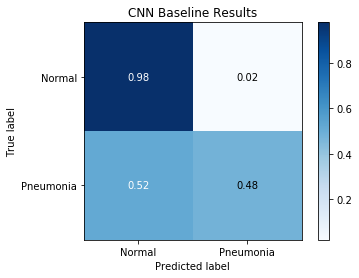

In [75]:
ax = plot_confusion_matrix(test_y, predictions_cnn, normalize = True)
plt.title('CNN Baseline Results')
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Normal', 'Pneumonia']);
plt.show()

## CNN with Padding 

In [76]:
# Define the callbacks
early_stopping_cnn = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_cnn_v2.h5', monitor='val_loss', save_best_only=True)]

In [77]:
cnn_model_v2 = models.Sequential()
cnn_model_v2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128, 3), padding = 'same'))
cnn_model_v2.add(layers.MaxPooling2D((2, 2)))

cnn_model_v2.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
cnn_model_v2.add(layers.MaxPooling2D((2, 2)))

cnn_model_v2.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
cnn_model_v2.add(layers.MaxPooling2D((2, 2)))

cnn_model_v2.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
cnn_model_v2.add(layers.MaxPooling2D((2, 2)))

cnn_model_v2.add(layers.Flatten())
cnn_model_v2.add(layers.Dense(512, activation='relu'))
cnn_model_v2.add(layers.Dense(1, activation='sigmoid'))

cnn_model_v2.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [78]:
cnn_model_v2 = cnn_model_v2.fit(train_images,
                    train_y,
                    epochs=50,
                    callbacks = early_stopping_cnn,
                    batch_size=64,
                    validation_data=(val_images, val_y))

Epoch 1/50
82/82 [==============================] - 62s 754ms/step - loss: 0.5843 - accuracy: 0.7352 - val_loss: 0.8144 - val_accuracy: 0.5000
Epoch 2/50
82/82 [==============================] - 59s 714ms/step - loss: 0.5520 - accuracy: 0.7429 - val_loss: 0.8247 - val_accuracy: 0.5000
Epoch 3/50
82/82 [==============================] - 60s 727ms/step - loss: 0.5119 - accuracy: 0.7550 - val_loss: 1.2420 - val_accuracy: 0.5000
Epoch 4/50
82/82 [==============================] - 62s 753ms/step - loss: 0.4728 - accuracy: 0.7876 - val_loss: 0.8627 - val_accuracy: 0.5000
Epoch 5/50
82/82 [==============================] - 63s 766ms/step - loss: 0.3928 - accuracy: 0.8330 - val_loss: 1.2005 - val_accuracy: 0.5000
Epoch 6/50
82/82 [==============================] - 59s 719ms/step - loss: 0.3282 - accuracy: 0.8673 - val_loss: 0.9605 - val_accuracy: 0.6250
Epoch 7/50
82/82 [==============================] - 59s 716ms/step - loss: 0.2376 - accuracy: 0.9126 - val_loss: 1.6957 - val_accuracy: 0.5000

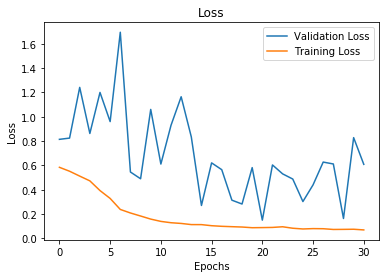

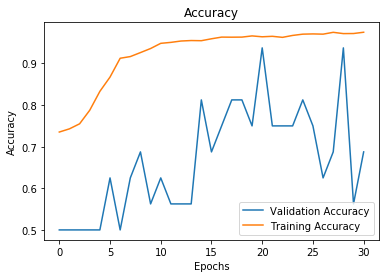

In [79]:
visualize_training_results(cnn_model_v2)

In [80]:
saved_model_cnn_v2 = load_model('Models/best_model_cnn_v2.h5')

In [81]:
results_train = saved_model_cnn_v2.evaluate(train_images, train_y)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model_cnn_v2.evaluate(test_images, test_y)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

163/163 [==============================] - 17s 105ms/step - loss: 0.1903 - accuracy: 0.9268
Training Loss: 0.19 
Training Accuracy: 0.927
----------
20/20 [==============================] - 2s 97ms/step - loss: 0.3791 - accuracy: 0.8558
Test Loss: 0.379 
Test Accuracy: 0.856


In [82]:
predictions_cnn_v2 = saved_model_cnn_v2.predict_classes(test_images)
print(classification_report(test_y, predictions_cnn_v2, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.84      0.95      0.89       390
   Pneumonia       0.89      0.71      0.79       234

    accuracy                           0.86       624
   macro avg       0.86      0.83      0.84       624
weighted avg       0.86      0.86      0.85       624



In [83]:
confusion_matrix_cnn = confusion_matrix(test_y, predictions_cnn_v2)
print(confusion_matrix_cnn)
confusion_matrix_cnn = confusion_matrix(test_y, predictions_cnn_v2, normalize =  'true')
print(confusion_matrix_cnn)

[[369  21]
 [ 69 165]]
[[0.94615385 0.05384615]
 [0.29487179 0.70512821]]


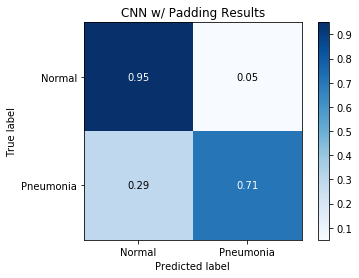

In [84]:
ax = plot_confusion_matrix(test_y, predictions_cnn_v2, normalize = True)
plt.title('CNN w/ Padding Results')
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Normal', 'Pneumonia']);
plt.show()

In [171]:
layer_outputs = [layer.output for layer in saved_model_cnn_v2.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=saved_model_cnn_v2.input, outputs=layer_outputs)

In [172]:
saved_model_cnn_v2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)      

(1, 128, 128, 32)


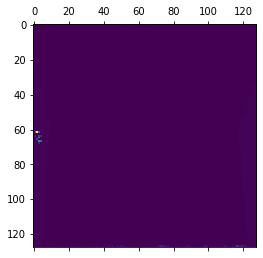

In [181]:
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

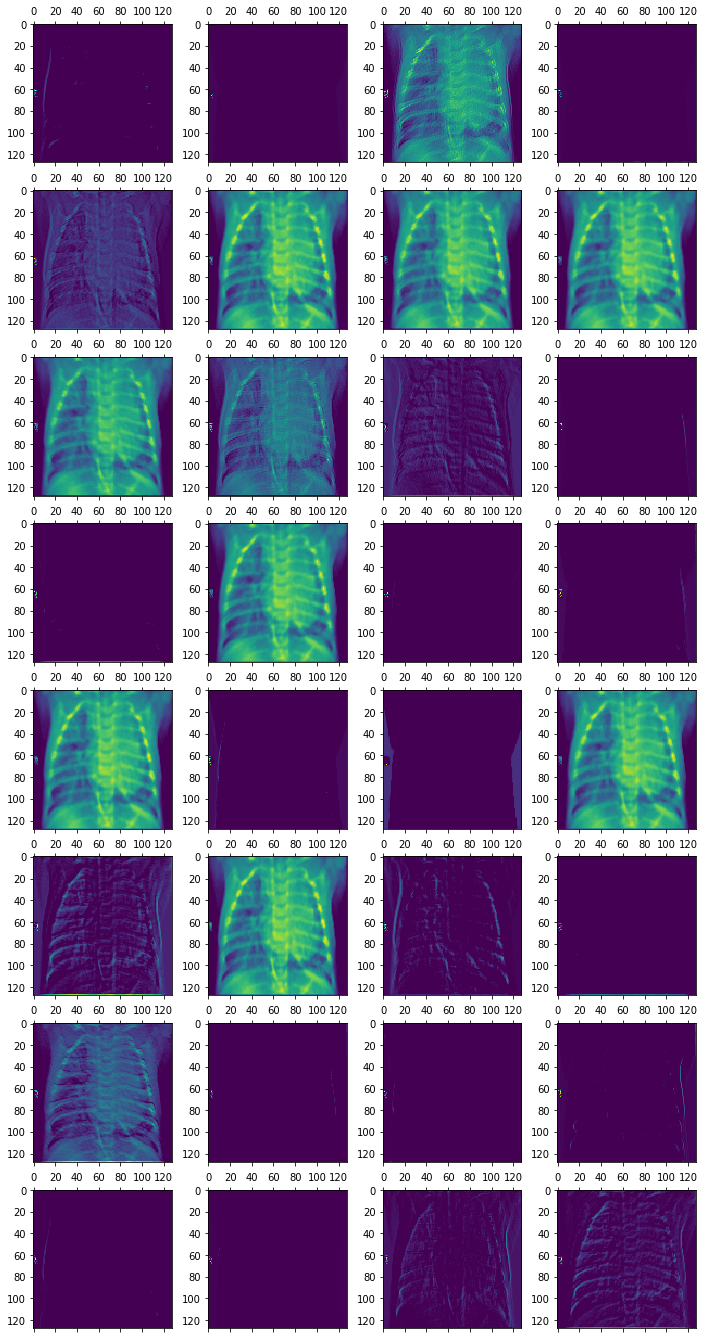

In [182]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

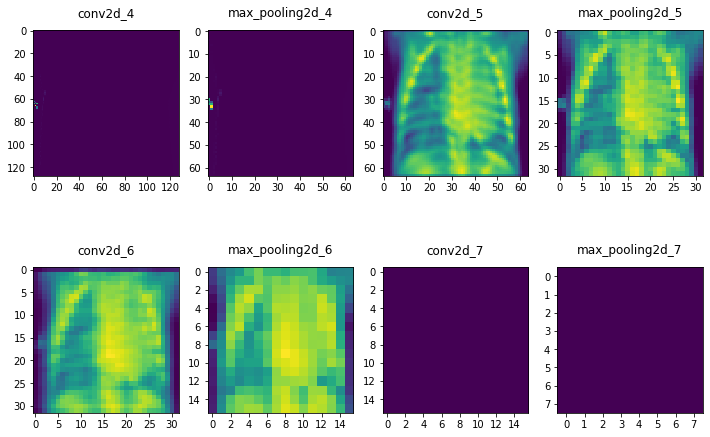

In [183]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in saved_model_cnn_v2.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

## CNN with Padding and Dropout

In [21]:
# Define the callbacks
early_stopping_cnn = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_cnn_v3.h5', monitor='val_loss', save_best_only=True)]

In [27]:
cnn_model_v3 = models.Sequential()
cnn_model_v3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128, 3), padding = 'same'))
cnn_model_v3.add(layers.MaxPooling2D((2, 2)))

cnn_model_v3.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
cnn_model_v3.add(layers.MaxPooling2D((2, 2)))

cnn_model_v3.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
cnn_model_v3.add(layers.MaxPooling2D((2, 2)))

cnn_model_v3.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
cnn_model_v3.add(layers.MaxPooling2D((2, 2)))

cnn_model_v3.add(layers.Flatten())
cnn_model_v3.add(layers.Dense(512, activation='relu'))
cnn_model_v3.add(layers.Dropout(0.2))
cnn_model_v3.add(layers.Dense(128, activation='relu'))
cnn_model_v3.add(layers.Dropout(0.2))
cnn_model_v3.add(layers.Dense(1, activation='sigmoid'))

cnn_model_v3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [28]:
cnn_model_v3 = cnn_model_v3.fit(train_images,
                    train_y,
                    epochs=50,
                    callbacks = early_stopping_cnn,
                    batch_size=64,
                    validation_data=(val_images, val_y))

Epoch 1/50
82/82 [==============================] - 67s 823ms/step - loss: 0.5854 - accuracy: 0.7429 - val_loss: 0.7706 - val_accuracy: 0.5000
Epoch 2/50
82/82 [==============================] - 66s 804ms/step - loss: 0.5580 - accuracy: 0.7429 - val_loss: 0.7380 - val_accuracy: 0.5000
Epoch 3/50
82/82 [==============================] - 73s 890ms/step - loss: 0.5193 - accuracy: 0.7494 - val_loss: 1.0109 - val_accuracy: 0.5000
Epoch 4/50
82/82 [==============================] - 78s 953ms/step - loss: 0.4712 - accuracy: 0.7822 - val_loss: 0.6657 - val_accuracy: 0.5000
Epoch 5/50
82/82 [==============================] - 76s 931ms/step - loss: 0.4003 - accuracy: 0.8253 - val_loss: 0.4861 - val_accuracy: 0.8125
Epoch 6/50
82/82 [==============================] - 74s 907ms/step - loss: 0.3327 - accuracy: 0.8622 - val_loss: 0.7494 - val_accuracy: 0.6250
Epoch 7/50
82/82 [==============================] - 79s 967ms/step - loss: 0.2563 - accuracy: 0.8919 - val_loss: 0.3766 - val_accuracy: 0.8125

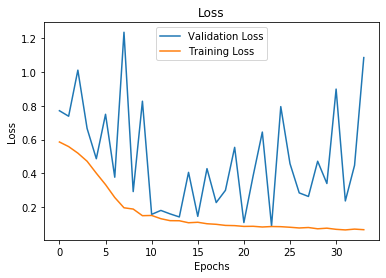

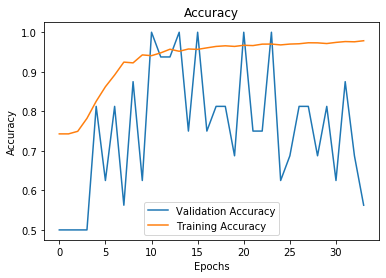

In [29]:
visualize_training_results(cnn_model_v3)

In [85]:
saved_model_cnn_v3 = load_model('Models/best_model_cnn_v3.h5')

In [86]:
results_train = saved_model_cnn_v3.evaluate(train_images, train_y)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model_cnn_v3.evaluate(test_images, test_y)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

163/163 [==============================] - 17s 103ms/step - loss: 0.1177 - accuracy: 0.9511
Training Loss: 0.118 
Training Accuracy: 0.951
----------
20/20 [==============================] - 2s 97ms/step - loss: 0.5018 - accuracy: 0.8317
Test Loss: 0.502 
Test Accuracy: 0.832


In [87]:
predictions_cnn_v3 = saved_model_cnn_v3.predict_classes(test_images)
print(classification_report(test_y, predictions_cnn_v3, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.81      0.96      0.88       390
   Pneumonia       0.90      0.62      0.73       234

    accuracy                           0.83       624
   macro avg       0.85      0.79      0.81       624
weighted avg       0.84      0.83      0.82       624



In [88]:
confusion_matrix_cnn = confusion_matrix(test_y, predictions_cnn_v3)
print(confusion_matrix_cnn)
confusion_matrix_cnn = confusion_matrix(test_y, predictions_cnn_v3, normalize =  'true')
print(confusion_matrix_cnn)

[[374  16]
 [ 89 145]]
[[0.95897436 0.04102564]
 [0.38034188 0.61965812]]


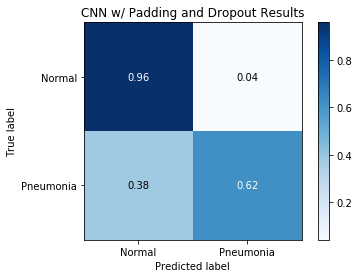

In [89]:
ax = plot_confusion_matrix(test_y, predictions_cnn_v3, normalize = True)
plt.title('CNN w/ Padding and Dropout Results')
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Normal', 'Pneumonia']);
plt.show()

## CNN with Data Augmentation

In [136]:
# Define the callbacks
early_stopping_cnn = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_cnn_v4.h5', monitor='val_loss', save_best_only=True)]

In [157]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(128, 128), 
        batch_size = 32, 
        class_mode='binary')

Found 5216 images belonging to 2 classes.


In [162]:
cnn_model_v4 = models.Sequential()
cnn_model_v4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128, 3), padding = 'same'))
cnn_model_v4.add(layers.MaxPooling2D((2, 2)))

cnn_model_v4.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
cnn_model_v4.add(layers.MaxPooling2D((2, 2)))

cnn_model_v4.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
cnn_model_v4.add(layers.MaxPooling2D((2, 2)))

cnn_model_v4.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
cnn_model_v4.add(layers.MaxPooling2D((2, 2)))

cnn_model_v4.add(layers.Flatten())
cnn_model_v4.add(layers.Dense(512, activation='relu'))
cnn_model_v4.add(layers.Dropout(0.2))
cnn_model_v4.add(layers.Dense(128, activation='relu'))
cnn_model_v4.add(layers.Dropout(0.2))
cnn_model_v4.add(layers.Dense(1, activation='sigmoid'))

cnn_model_v4.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [163]:
history = cnn_model_v4.fit_generator(train_generator,
                                       epochs=50,
                                       callbacks=early_stopping_cnn,
                                       validation_data=val_generator
                                      )

Epoch 1/50
163/163 [==============================] - 130s 800ms/step - loss: 0.5503 - accuracy: 0.7481 - val_loss: 1.1832 - val_accuracy: 0.5000
Epoch 2/50
163/163 [==============================] - 131s 807ms/step - loss: 0.4031 - accuracy: 0.8035 - val_loss: 1.4760 - val_accuracy: 0.5000
Epoch 3/50
163/163 [==============================] - 130s 797ms/step - loss: 0.3410 - accuracy: 0.8447 - val_loss: 1.4753 - val_accuracy: 0.5000
Epoch 4/50
163/163 [==============================] - 138s 846ms/step - loss: 0.2988 - accuracy: 0.8700 - val_loss: 1.2558 - val_accuracy: 0.5000
Epoch 5/50
163/163 [==============================] - 132s 807ms/step - loss: 0.2753 - accuracy: 0.8804 - val_loss: 1.6537 - val_accuracy: 0.5000
Epoch 6/50
163/163 [==============================] - 136s 837ms/step - loss: 0.2407 - accuracy: 0.8978 - val_loss: 1.5918 - val_accuracy: 0.5000
Epoch 7/50
163/163 [==============================] - 130s 801ms/step - loss: 0.2392 - accuracy: 0.8997 - val_loss: 1.7128 -

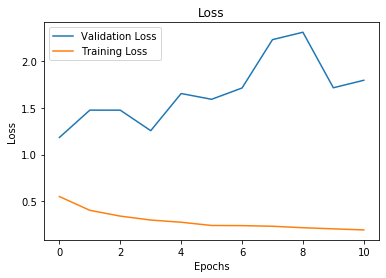

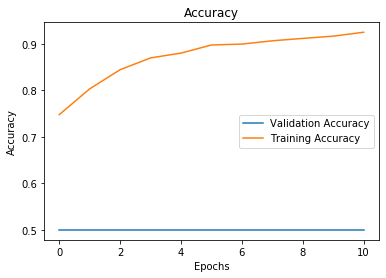

In [165]:
visualize_training_results(history)

In [166]:
saved_model_cnn_v4 = load_model('Models/best_model_cnn_v4.h5')

In [167]:
results_train = saved_model_cnn_v4.evaluate(train_images, train_y)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model_cnn_v4.evaluate(test_images, test_y)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

ValueError: Data cardinality is ambiguous:
  x sizes: 32
  y sizes: 5216
Please provide data which shares the same first dimension.

In [168]:
predictions_cnn_v4 = saved_model_cnn_v4.predict_classes(test_images)
print(classification_report(test_y, predictions_cnn_v4, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.38      0.13      0.19       390
   Pneumonia       0.31      0.64      0.41       234

    accuracy                           0.32       624
   macro avg       0.34      0.39      0.30       624
weighted avg       0.35      0.32      0.28       624



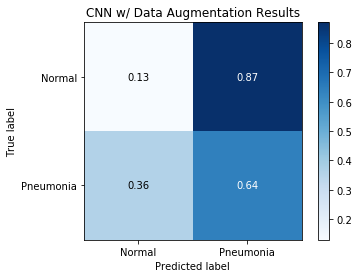

In [169]:
ax = plot_confusion_matrix(test_y, predictions_cnn_v4, normalize = True)
plt.title('CNN w/ Data Augmentation Results')
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Normal', 'Pneumonia']);
plt.show()

# Pre-Trained Models

## VGG19

In [103]:
# Define the callbacks
early_stopping_pretrain = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_pretrain.h5', monitor='val_loss', save_best_only=True)]

In [99]:
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(128, 128, 3))

# Define Model Architecture
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

cnn_base.trainable = False

# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model 
print(len(model.trainable_weights))

model.summary()

vgg19 False
flatten_9 True
dense_40 True
dense_41 True
dense_42 True
dense_43 True
dense_44 True
10
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                524352    
_________________________________________________________________
dense_41 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_42 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_43 (Dense)             (None, 128)               32896     
___________________

In [104]:
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

# Fitting the Model
model = model.fit(train_images,
                        train_y,
                        epochs=50,
                        callbacks = early_stopping_pretrain,
                        batch_size=64,
                        validation_data=(val_images, val_y))


end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/50
82/82 [==============================] - 277s 3s/step - loss: 0.2138 - accuracy: 0.9158 - val_loss: 0.2990 - val_accuracy: 0.8750
Epoch 2/50
82/82 [==============================] - 278s 3s/step - loss: 0.1679 - accuracy: 0.9312 - val_loss: 0.2887 - val_accuracy: 0.8750
Epoch 3/50
82/82 [==============================] - 276s 3s/step - loss: 0.1524 - accuracy: 0.9375 - val_loss: 0.2507 - val_accuracy: 0.8125
Epoch 4/50
82/82 [==============================] - 275s 3s/step - loss: 0.1635 - accuracy: 0.9363 - val_loss: 0.2752 - val_accuracy: 0.8750
Epoch 5/50
82/82 [==============================] - 277s 3s/step - loss: 0.1203 - accuracy: 0.9526 - val_loss: 0.2370 - val_accuracy: 0.8125
Epoch 6/50
82/82 [==============================] - 275s 3s/step - loss: 0.1403 - accuracy: 0.9473 - val_loss: 1.2710 - val_accuracy: 0.5000
Epoch 7/50
82/82 [==============================] - 275s 3s/step - loss: 0.1097 - accuracy: 0.9582 - val_loss: 0.3187 - val_accuracy: 0.8750
Epoch 8/50
82

NameError: name 'datetime' is not defined

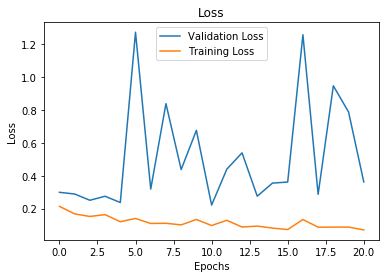

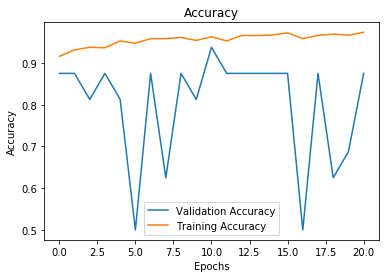

In [106]:
visualize_training_results(model)

In [90]:
saved_model_pretrain = load_model('Models/best_model_pretrain.h5')

In [91]:
results_train = saved_model_pretrain.evaluate(train_images, train_y)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model_pretrain.evaluate(test_images, test_y)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

163/163 [==============================] - 270s 2s/step - loss: 0.1178 - accuracy: 0.9563
Training Loss: 0.118 
Training Accuracy: 0.956
----------
20/20 [==============================] - 32s 2s/step - loss: 0.3953 - accuracy: 0.8606
Test Loss: 0.395 
Test Accuracy: 0.861


In [92]:
predictions_pretrain = saved_model_pretrain.predict_classes(test_images)
print(classification_report(test_y, predictions_pretrain, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.83      0.98      0.90       390
   Pneumonia       0.95      0.66      0.78       234

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.87      0.86      0.85       624



In [93]:
confusion_matrix_cnn = confusion_matrix(test_y, predictions_pretrain)
print(confusion_matrix_cnn)
confusion_matrix_cnn = confusion_matrix(test_y, predictions_pretrain, normalize =  'true')
print(confusion_matrix_cnn)

[[382   8]
 [ 79 155]]
[[0.97948718 0.02051282]
 [0.33760684 0.66239316]]


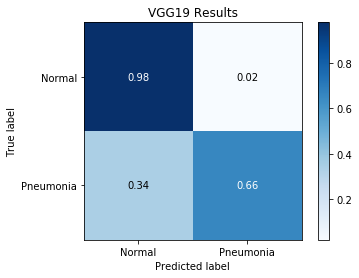

In [94]:
ax = plot_confusion_matrix(test_y, predictions_pretrain, normalize = True)
plt.title('VGG19 Results')
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Normal', 'Pneumonia']);
plt.show()

## Xception

In [114]:
# Define the callbacks
early_stopping_pretrain = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_pretrain_2.h5', monitor='val_loss', save_best_only=True)]

In [121]:
from keras.applications import Xception
cnn_base = Xception(weights='imagenet',
                 include_top=False,
                 input_shape=(128, 128, 3))

# Define Model Architecture
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

cnn_base.trainable = False

# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model 
print(len(model.trainable_weights))

model.summary()

xception False
flatten_15 True
dense_70 True
dense_71 True
dense_72 True
dense_73 True
dense_74 True
10
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_15 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_70 (Dense)             (None, 64)                2097216   
_________________________________________________________________
dense_71 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_72 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_73 (Dense)             (None, 128)               32896     
_______________

In [122]:
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

# Fitting the Model
model = model.fit(train_images,
                        train_y,
                        epochs=50,
                        callbacks = early_stopping_pretrain,
                        batch_size=64,
                        validation_data=(val_images, val_y))


end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/50
82/82 [==============================] - 101s 1s/step - loss: 0.3031 - accuracy: 0.8675 - val_loss: 0.7322 - val_accuracy: 0.7500
Epoch 2/50
82/82 [==============================] - 102s 1s/step - loss: 0.1852 - accuracy: 0.9254 - val_loss: 0.4134 - val_accuracy: 0.8750
Epoch 3/50
82/82 [==============================] - 100s 1s/step - loss: 0.1636 - accuracy: 0.9362 - val_loss: 0.4737 - val_accuracy: 0.8125
Epoch 4/50
82/82 [==============================] - 100s 1s/step - loss: 0.1476 - accuracy: 0.9419 - val_loss: 0.5831 - val_accuracy: 0.7500
Epoch 5/50
82/82 [==============================] - 100s 1s/step - loss: 0.1334 - accuracy: 0.9475 - val_loss: 0.4359 - val_accuracy: 0.8125
Epoch 6/50
82/82 [==============================] - 101s 1s/step - loss: 0.1162 - accuracy: 0.9569 - val_loss: 1.2077 - val_accuracy: 0.6250
Epoch 7/50
82/82 [==============================] - 100s 1s/step - loss: 0.1042 - accuracy: 0.9597 - val_loss: 0.7896 - val_accuracy: 0.6875
Epoch 8/50
82

NameError: name 'start' is not defined

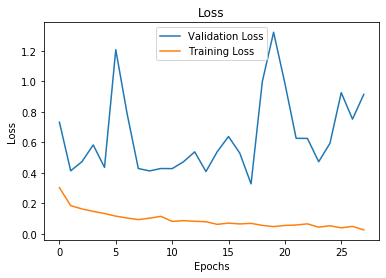

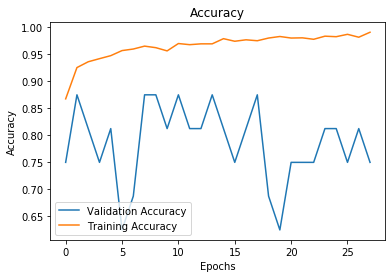

In [123]:
visualize_training_results(model)

In [95]:
saved_model_pretrain = load_model('Models/best_model_pretrain_2.h5')

In [96]:
results_train = saved_model_pretrain.evaluate(train_images, train_y)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model_pretrain.evaluate(test_images, test_y)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

163/163 [==============================] - 101s 620ms/step - loss: 0.1835 - accuracy: 0.9130
Training Loss: 0.184 
Training Accuracy: 0.913
----------
20/20 [==============================] - 12s 578ms/step - loss: 0.2930 - accuracy: 0.8846
Test Loss: 0.293 
Test Accuracy: 0.885


In [97]:
predictions_pretrain = saved_model_pretrain.predict_classes(test_images)
print(classification_report(test_y, predictions_pretrain, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.90      0.92      0.91       390
   Pneumonia       0.86      0.83      0.84       234

    accuracy                           0.88       624
   macro avg       0.88      0.87      0.88       624
weighted avg       0.88      0.88      0.88       624



In [98]:
confusion_matrix_cnn = confusion_matrix(test_y, predictions_pretrain)
print(confusion_matrix_cnn)
confusion_matrix_cnn = confusion_matrix(test_y, predictions_pretrain, normalize =  'true')
print(confusion_matrix_cnn)

[[358  32]
 [ 40 194]]
[[0.91794872 0.08205128]
 [0.17094017 0.82905983]]


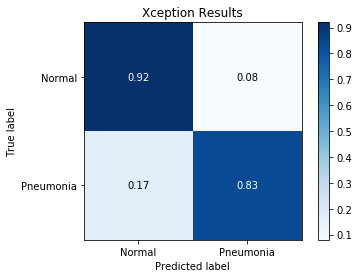

In [170]:
ax = plot_confusion_matrix(test_y, predictions_pretrain, normalize = True)
plt.title('Xception Results')
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Normal', 'Pneumonia']);
plt.show()

# Final Remarks:

Xception performed the best out of all the models tested. Its accuracy and recall is closest to what the medical field would desire, namely high overall accuracy and high accuracy correctly diagnosing patients. 